In [1]:
pip install squarify

Note: you may need to restart the kernel to use updated packages.


In [2]:
# import libraries
import pandas as pd
from datetime import timedelta
import matplotlib.pyplot as plt
import squarify

import warnings
warnings.filterwarnings('ignore')

In [3]:
data = pd.read_csv("data.csv",encoding = "ISO-8859-1")

In [4]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [6]:
# convert date object to datetime
data["InvoiceDate"] = pd.to_datetime(data["InvoiceDate"])

In [7]:
# total sum for data
data["TotalSum"] = data["Quantity"] * data["UnitPrice"]

instant_data = data["InvoiceDate"].max() + timedelta(days=1)
print(instant_data)

2011-12-10 12:50:00


In [8]:
data_process = data.groupby(["CustomerID"]).agg({
    "InvoiceDate": lambda x: (instant_data - x.max()).days,
    "InvoiceNo": 'count',
    "TotalSum":'sum'})

In [9]:
# rename columns
data_process.rename(columns={"InvoiceDate": 'Recency',
                             "InvoiceNo": 'Frequency',
                             "TotalSum": 'MonetaryValue'},inplace=True)

In [10]:
data_process_copy=data_process.copy()

In [11]:
data_process_copy.head()

,Recency,Frequency,MonetaryValue
CustomerID,,,
12346.0,326,2,0.00
12347.0,2,182,4310.00
12348.0,75,31,1797.24
12349.0,19,73,1757.55
12350.0,310,17,334.40


In [12]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalSum
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


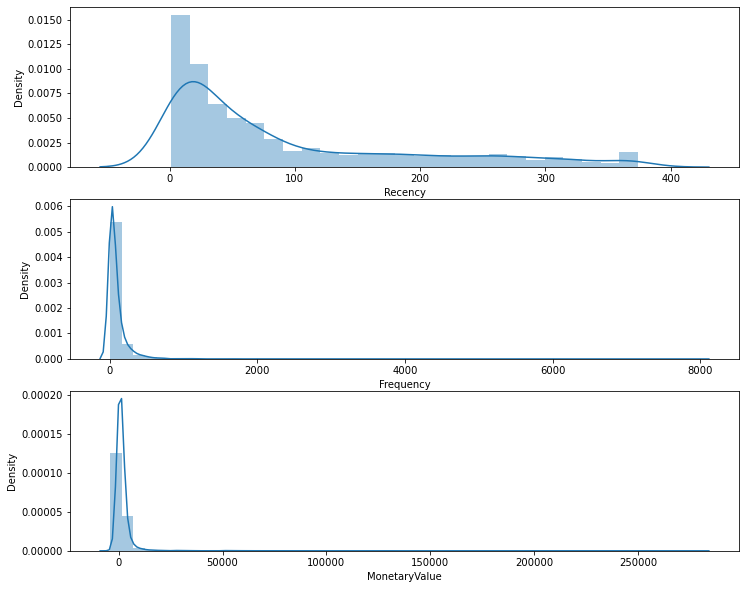

In [13]:
import seaborn as sns
# Plot RFM distributions
plt.figure(figsize=(12,10))
# Plot distribution of Recency
plt.subplot(3, 1, 1); sns.distplot(data_process['Recency'])
# Plot distribution of Frequency
plt.subplot(3, 1, 2); sns.distplot(data_process['Frequency'])
# Plot distribution of MonetaryValue
plt.subplot(3, 1, 3); sns.distplot(data_process['MonetaryValue'])
# Show the plot
plt.show()

### RFM segments

In [14]:
# Create labels for Recency and Frequency
r_labels = range(4, 0, -1); f_labels = range(1,5)
# Assign these labels to 4 equal percentile groups
r_groups = pd.qcut(data_process["Recency"], q=4, labels=r_labels)
# Assign these labels to 4 equal percentile groups 
f_groups = pd.qcut(data_process["Frequency"], q=4, labels=f_labels)
# Create new columns R and F
data_process = data_process.assign(R=r_groups.values, F=f_groups.values)
data_process.head()

,Recency,Frequency,MonetaryValue,R,F
CustomerID,,,,,
12346.0,326,2,0.00,1,1
12347.0,2,182,4310.00,4,4
12348.0,75,31,1797.24,2,2
12349.0,19,73,1757.55,3,3
12350.0,310,17,334.40,1,1


In [15]:
# create labels for MonetaryValue
m_labels = range(1, 5)

m_groups = pd.qcut(data_process["MonetaryValue"], q=4, labels=m_labels)

# create m 
data_process = data_process.assign(M = m_groups.values)

In [16]:
# concat RFM to create RFM segments
def join_rfm(x):
    return str(x['R']) + str(x['F']) + str(x['M'])

data_process["RFM_segments"] = data_process.apply(join_rfm, axis=1)

rfm = data_process
rfm.head()

,Recency,Frequency,MonetaryValue,R,F,M,RFM_segments
CustomerID,,,,,,,
12346.0,326,2,0.00,1,1,1,1.01.01.0
12347.0,2,182,4310.00,4,4,4,4.04.04.0
12348.0,75,31,1797.24,2,2,4,2.02.04.0
12349.0,19,73,1757.55,3,3,4,3.03.04.0
12350.0,310,17,334.40,1,1,2,1.01.02.0


In [17]:
rfm_count_unique = rfm.groupby('RFM_segments')['RFM_segments'].nunique()
print(rfm_count_unique.sum())

62


### summing score

In [18]:
rfm["RFM_score"] = rfm[["R","F","M"]].sum(axis=1)
print(rfm['RFM_score'].head())

CustomerID
12346.0     3
12347.0    12
12348.0     8
12349.0    10
12350.0     4
Name: RFM_score, dtype: int64


### For RFM segments
If the R-F-M 444 This customer will be a customer who has made a shopping fairly recently, has made frequent purchases and bought high-priced products in these purchases.

In [19]:
# en iyi 
print("Best Customers: ",len(rfm[rfm['RFM_segments']=='444']))
# en çok gelen
print('Loyal Customers: ',len(rfm[rfm['F']==4]))
# en çok harcama yapan
print("Big Spenders: ",len(rfm[rfm['M']==4]))
# gidici müşteri
print('Almost Lost: ', len(rfm[rfm['RFM_segments']=='244']))
# gitmiş müşteri
print('Lost Customers: ',len(rfm[rfm['RFM_segments']=='144']))
# gitmiş + ucuz
print('Lost Cheap Customers: ',len(rfm[rfm['RFM_segments']=='111']))

Best Customers:  0
Loyal Customers:  1081
Big Spenders:  1093
Almost Lost:  0
Lost Customers:  0
Lost Cheap Customers:  0


In [20]:
rfm.head()

,Recency,Frequency,MonetaryValue,R,F,M,RFM_segments,RFM_score
CustomerID,,,,,,,,
12346.0,326,2,0.00,1,1,1,1.01.01.0,3
12347.0,2,182,4310.00,4,4,4,4.04.04.0,12
12348.0,75,31,1797.24,2,2,4,2.02.04.0,8
12349.0,19,73,1757.55,3,3,4,3.03.04.0,10
12350.0,310,17,334.40,1,1,2,1.01.02.0,4


### RFM segment sum() score for  RFM level

In [21]:
# rfm_level
def rfm_level(rfm):
    if rfm["RFM_score"] >= 9:
        return 'Can\'t loose them'
    elif ((rfm["RFM_score"] >=8) and (rfm["RFM_score"] <9)):
        return "Champions"
    elif ((rfm['RFM_score'] >= 7) and (rfm['RFM_score'] < 8)):
        return 'Loyal'
    elif ((rfm['RFM_score'] >= 6) and (rfm['RFM_score'] < 7)):
        return 'Potential'
    elif ((rfm['RFM_score'] >= 5) and (rfm['RFM_score'] < 6)):
        return 'Promising'
    elif ((rfm['RFM_score'] >= 4) and (rfm['RFM_score'] < 5)):
        return 'Needs Attention'
    else:
        return 'Require Activation'
    
# Create a new variable RFM_Level
rfm['RFM_Level'] = rfm.apply(rfm_level, axis=1)
# Print the header with top 5 rows to the console
rfm.head()

,Recency,Frequency,MonetaryValue,R,F,M,RFM_segments,RFM_score,RFM_Level
CustomerID,,,,,,,,,
12346.0,326,2,0.00,1,1,1,1.01.01.0,3,Require Activation
12347.0,2,182,4310.00,4,4,4,4.04.04.0,12,Can't loose them
12348.0,75,31,1797.24,2,2,4,2.02.04.0,8,Champions
12349.0,19,73,1757.55,3,3,4,3.03.04.0,10,Can't loose them
12350.0,310,17,334.40,1,1,2,1.01.02.0,4,Needs Attention


### group customer with rfm level

In [22]:
# Calculate average values for each RFM_Level, and return a size of each segment 
rfm_level_agg = rfm.groupby('RFM_Level').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'MonetaryValue': ['mean', 'count']
}).round(1)
# Print the aggregated dataset
print(rfm_level_agg)

                   Recency Frequency MonetaryValue      
                      mean      mean          mean count
RFM_Level                                               
Can't loose them      25.2     195.1        4130.3  1690
Champions             62.7      57.0         974.7   467
Loyal                 78.8      39.7         724.2   447
Needs Attention      174.5      13.9         227.1   391
Potential             94.3      28.5         491.8   468
Promising            153.0      21.2         346.8   517
Require Activation   264.8       7.8         109.1   392


### Analysis of rfm values

<AxesSubplot:xlabel='Recency'>

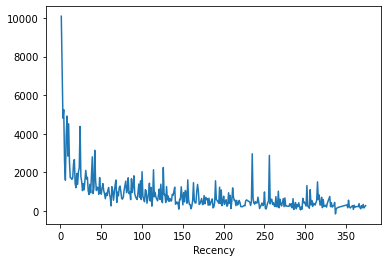

In [23]:
# (last purchase) / frequency and total amount of purchases
rfm.groupby('Recency')['MonetaryValue'].mean().plot()

<AxesSubplot:xlabel='Frequency'>

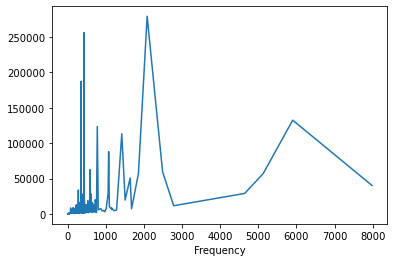

In [24]:
# recent and shopping total amount
data_process.groupby('Frequency')['MonetaryValue'].mean().plot()

<AxesSubplot:xlabel='RFM_score'>

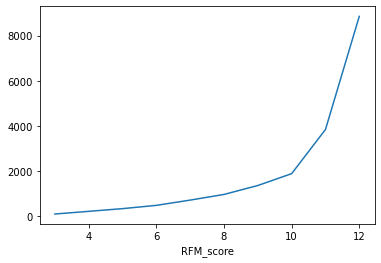

In [25]:
# recent and shopping total amount
data_process.groupby('RFM_score')['MonetaryValue'].mean().plot()

<AxesSubplot:xlabel='RFM_score'>

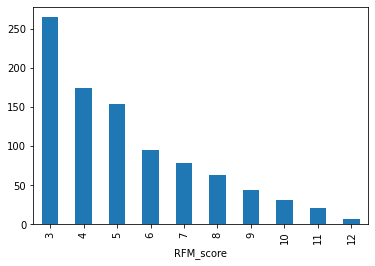

In [26]:
rfm.groupby('RFM_score').agg('Recency').mean().plot(kind='bar')

<AxesSubplot:xlabel='RFM_score'>

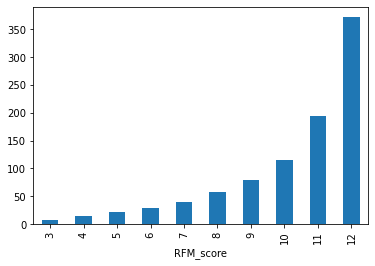

In [27]:
rfm.groupby('RFM_score').agg('Frequency').mean().plot(kind='bar')

<AxesSubplot:xlabel='RFM_score'>

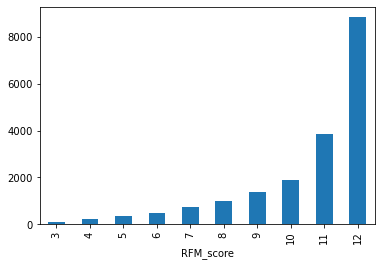

In [28]:
rfm.groupby('RFM_score').agg('MonetaryValue').mean().plot(kind='bar')

### what to do according to the user
 
- Potential - free items for loyal customers on their next purchase
- Promising - user known for purchase amount and spend. Discount can be added to wish list that has long passed since last purchase
- Needs Attention - it's been a long time since your first purchase. He may have had a bad experience or could not find the product he wanted
-Require Activation - the lowest performance may have gone to a different brand / site

### visualization

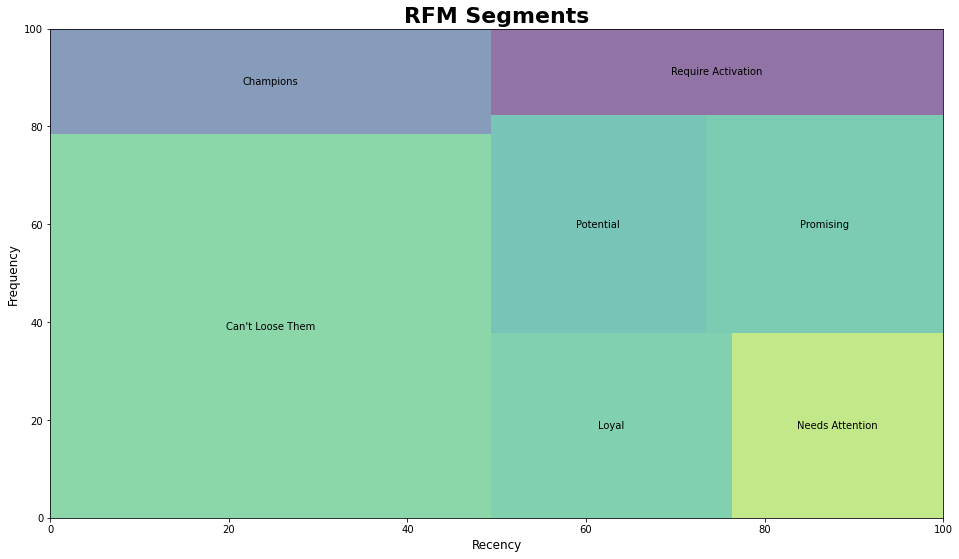

In [29]:
rfm_level_agg.columns = ['Recencymean','Frequencymean', 'Monetarymean','Count']
#Create our plot and resize it.
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(16, 9)
squarify.plot(sizes=rfm_level_agg['Count'], 
               label=['Can\'t Loose Them',
                     'Champions',
                     'Loyal',
                     'Needs Attention',
                     'Potential', 
                     'Promising', 
                     'Require Activation'], alpha=.6 )
plt.title("RFM Segments",fontsize=22,fontweight="bold")
ax.set_xlabel('Recency',fontsize=12)
ax.set_ylabel('Frequency',fontsize=12)
plt.axis('on')
plt.show()